<a href="https://colab.research.google.com/github/Nelson-iitp/2121CS07_CS575/blob/main/Assignment_4/%5BSOLUTION%5D_CS575_Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
pip show statsmodels 

Name: statsmodels
Version: 0.10.2
Summary: Statistical computations and models for Python
Home-page: https://www.statsmodels.org/
Author: None
Author-email: None
License: BSD License
Location: /usr/local/lib/python3.7/dist-packages
Requires: scipy, pandas, numpy, patsy
Required-by: plotnine


In [2]:
pip install statsmodels==0.12.2

     |████████████████████████████████| 9.5MB 3.8MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
pip show statsmodels 

Name: statsmodels
Version: 0.12.2
Summary: Statistical computations and models for Python
Home-page: https://www.statsmodels.org/
Author: None
Author-email: None
License: BSD License
Location: /usr/local/lib/python3.7/dist-packages
Requires: scipy, patsy, pandas, numpy
Required-by: plotnine


# [] REQUIRED []

In [4]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import statsmodels.tsa as tsa
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#============================================================== GLOBAL DECLEARATION
fs_norm = (12,8)
def plotCF(Y, Lags, include_L0):
  fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
  plot_acf(Y,lags=Lags,zero=include_L0,ax=ax1)
  plot_pacf(Y,lags=Lags,zero=include_L0,ax=ax2)
  plt.show()

#3
def get_NSE(e,s):
  _e = np.mean(e)
  return 1 - ( np.sum((e-s)**2) / np.sum((e-_e)**2) )


#5
def get_CC(e,s):
  _e, _s = np.mean(e), np.mean(s)
  return np.sum((e-_e)*(s-_s)) / ((np.sum((e-_e)**2))**0.5 * (np.sum((s-_s)**2))**0.5)

#6
def get_r2(e,s):
  return get_CC(e,s)**2

#7
def get_MSE(e,s):
  N=len(e)
  return np.sum((e-s)**2)/N

#8
def get_RMSE(e,s):
  return get_MSE(e,s)**0.5



# QUESTION

Fit an AR, MA, ARMA, ARIMA, and SARIMA model on the electric production (Electric_Production.csv) and johnson & johnson dataset (jj.csv):

	a. Test for stationarity (try all methods taught in class). 

	b. With the help of graphs, discuss evidence of seasonality and nonstationarity. Is there a seasonality?

	c. Obtain predictions for the 1, 2, 3, 4 subsequent years (To obtain the values of p,d,q please plot ACF and PACF graphs.) . Do in-sampling only (not futuristic)

	d. Calculate RMSE, R-squared, NSE for all models. 

	e. Plot the forecasted values and original values of the data obtained by all the models.
  
	f. Compare the forecast based on plots and accuracies.

# Load Data

In [5]:

 #  Jonson Dataset
DS_JS_path = "https://raw.githubusercontent.com/cs575ts/Assignments/main/Assignment_4/jj.csv"
db = np.loadtxt(DS_JS_path,  dtype='str', skiprows=1, delimiter=",") # "1960-01-01",0.71
DS_JS_n = len(db)
DS_JS_d = db[:,1].astype('float')
DS_JS_t = np.zeros(len(db), dtype='object')
for i in range(0, len(db)):
  #DS_JS_t[i] = np.datetime64(db[i,0][1:-1]) 
  DS_JS_t[i] = datetime.datetime.strptime(db[i,0], '"%Y-%m-%d"'  )
print('db@',DS_JS_path)
print('len',DS_JS_n, db.shape)
print(DS_JS_t.shape, DS_JS_d.shape)

print('')
 #  Electric Prod Dataset
DS_EP_path = "https://raw.githubusercontent.com/cs575ts/Assignments/main/Assignment_4/Electric_Production.csv"
db = np.loadtxt(DS_EP_path,  dtype='str', skiprows=1, delimiter=",") # 1/1/1999,102.1348
DS_EP_n = len(db)
DS_EP_d = db[:,1].astype('float')
DS_EP_t = np.zeros(len(db), dtype='object')
for i in range(0, len(db)):
  #DS_JS_t[i] = np.datetime64(db[i,0][1:-1]) 
  DS_EP_t[i] = datetime.datetime.strptime(db[i,0], '%m/%d/%Y'  )
print('db@',DS_EP_path)
print('len',DS_EP_n,db.shape)
print(DS_EP_t.shape, DS_EP_d.shape)


db@ https://raw.githubusercontent.com/cs575ts/Assignments/main/Assignment_4/jj.csv
len 84 (84, 2)
(84,) (84,)

db@ https://raw.githubusercontent.com/cs575ts/Assignments/main/Assignment_4/Electric_Production.csv
len 397 (397, 2)
(397,) (397,)


# [DEF] KPSS and ADF Test

In [8]:
# define adf and kpss testing

def adf_test(ds, p_threshold , details = False):
  res=""
  res += '\nADF-Test Hypothesis :: Series is Non-Stationary\n'
  timeseries = ds.dropna()
  dftest =  tsa.stattools.adfuller(timeseries,  regression='c', autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] =  (value, getHres(dftest[0],value) )

  if details:
    res+=str(dfoutput)+"\n"

  #if dftest[1]<p_threshold: # hypothesis is false = Rejected
  #if dftest[1]>p_threshold: # hypothesis is true = cannot reject
  resb =  (dftest[1]>=p_threshold)
  res+= "RESULT :: Hypothesis is "+str( resb )
  
  return res, resb, dftest[1]

def kpss_test(ds, p_threshold , details = False):
  res=""
  res += '\nKPSS-Test Hypothesis :: Series is Trend-Stationary\n'
  timeseries = ds.dropna()
  kpsstest = tsa.stattools.kpss(timeseries, regression='ct')
  kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
  for key,value in kpsstest[3].items():
      kpss_output['Critical Value (%s)'%key] =  (value, getHres(value,kpsstest[0]) )
  
  if details:
    res+=str(kpss_output)+"\n"

  #if kpsstest[1]<p_threshold: # hypothesis is false = Rejected
  #if kpsstest[1]>p_threshold: # hypothesis is true = cannot reject
  resb =  (kpsstest[1]>=p_threshold)
  res+= "RESULT :: Hypothesis is "+str( resb )
  return res, resb, kpsstest[1]

def getHres(test_stat, crit_val):
  if test_stat<crit_val:
    return "Hypothesis: False"
  else:
    return "Hypothesis: True"
   

## Start testing ...

### JS Dataset

-----------------------------------------------------------------------


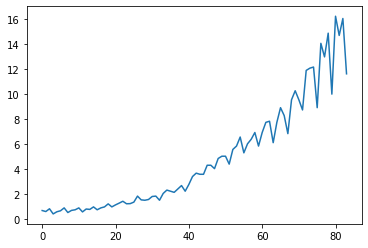

-----------------------------------------------------------------------

ADF-Test Hypothesis :: Series is Non-Stationary
Test Statistic                                                 2.74202
p-value                                                              1
#Lags Used                                                          11
Number of Observations Used                                         72
Critical Value (1%)             (-3.524624466842421, Hypothesis: True)
Critical Value (5%)            (-2.9026070739026064, Hypothesis: True)
Critical Value (10%)           (-2.5886785262345677, Hypothesis: True)
dtype: object
RESULT :: Hypothesis is True
-----------------------------------------------------------------------

KPSS-Test Hypothesis :: Series is Trend-Stationary
Test Statistic                             0.198576
p-value                                   0.0165341
Lags Used                                        12
Critical Value (10%)     (0.119, Hypothesis: False)
Critica

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


In [9]:
thresh, show_details =  0.05, True #<---------- set pvalue threshold here


data = pd.Series( (DS_JS_d))
print("-----------------------------------------------------------------------")

plt.plot(data)
plt.show()
print("-----------------------------------------------------------------------")

tRes, bRes, pRes = adf_test(data,thresh,details=show_details)
print(tRes)
print("-----------------------------------------------------------------------")

tRes, bRes, pRes = kpss_test(data,thresh,details=show_details)
print(tRes)
print("-----------------------------------------------------------------------")
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")



### EP Dataset

-----------------------------------------------------------------------


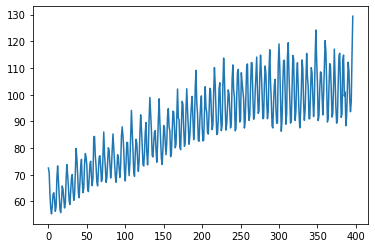

-----------------------------------------------------------------------

ADF-Test Hypothesis :: Series is Non-Stationary
Test Statistic                                                -2.25699
p-value                                                       0.186215
#Lags Used                                                          15
Number of Observations Used                                        381
Critical Value (1%)            (-3.4476305904172904, Hypothesis: True)
Critical Value (5%)             (-2.869155980820355, Hypothesis: True)
Critical Value (10%)            (-2.570827146203181, Hypothesis: True)
dtype: object
RESULT :: Hypothesis is True
-----------------------------------------------------------------------

KPSS-Test Hypothesis :: Series is Trend-Stationary
Test Statistic                             0.488278
p-value                                        0.01
Lags Used                                        17
Critical Value (10%)     (0.119, Hypothesis: False)
Critica

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


In [10]:
thresh, show_details =  0.05, True #<---------- set pvalue threshold here


data = pd.Series( (DS_EP_d))
print("-----------------------------------------------------------------------")

plt.plot(data)
plt.show()
print("-----------------------------------------------------------------------")

tRes, bRes, pRes = adf_test(data,thresh,details=show_details)
print(tRes)
print("-----------------------------------------------------------------------")

tRes, bRes, pRes = kpss_test(data,thresh,details=show_details)
print(tRes)
print("-----------------------------------------------------------------------")
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")



## Convert 2 Stationary

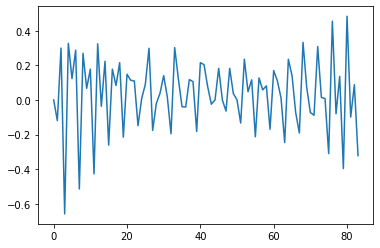

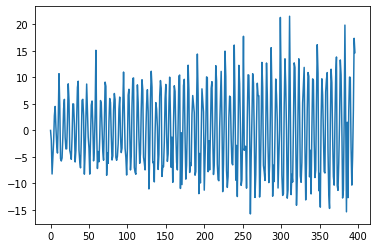

In [11]:
# differencing
def c2s_differencing(Y, lag):
  res = np.zeros(len(Y))
  res[lag:] = Y[lag:] - Y[0:-lag]
  return res

DS_JS_ds = c2s_differencing( np.log(DS_JS_d), 1 )
DS_EP_ds = c2s_differencing( DS_EP_d, 1 )

plt.plot(DS_JS_ds)
plt.show()

plt.plot(DS_EP_ds)
plt.show()

## Start Retesting ...

### JP Dataset

-----------------------------------------------------------------------


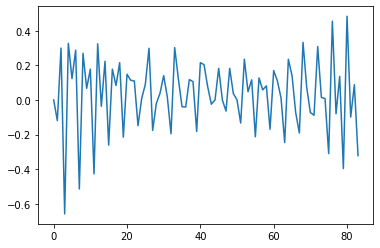

-----------------------------------------------------------------------

ADF-Test Hypothesis :: Series is Non-Stationary
Test Statistic                                                 -6.06453
p-value                                                     1.19051e-07
#Lags Used                                                            4
Number of Observations Used                                          79
Critical Value (1%)            (-3.5159766913976376, Hypothesis: False)
Critical Value (5%)             (-2.898885703483903, Hypothesis: False)
Critical Value (10%)           (-2.5866935058484217, Hypothesis: False)
dtype: object
RESULT :: Hypothesis is False
-----------------------------------------------------------------------

KPSS-Test Hypothesis :: Series is Trend-Stationary
Test Statistic                              0.12695
p-value                                    0.085277
Lags Used                                        12
Critical Value (10%)     (0.119, Hypothesis: False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


In [12]:
thresh, show_details =  0.05, True #<---------- set pvalue threshold here


data = pd.Series( (DS_JS_ds))
print("-----------------------------------------------------------------------")

plt.plot(data)
plt.show()
print("-----------------------------------------------------------------------")

tRes, bRes, pRes = adf_test(data,thresh,details=show_details)
print(tRes)
print("-----------------------------------------------------------------------")

tRes, bRes, pRes = kpss_test(data,thresh,details=show_details)
print(tRes)
print("-----------------------------------------------------------------------")
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")



### EP Dataset

-----------------------------------------------------------------------


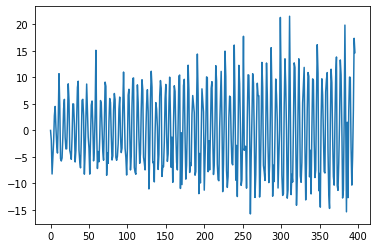

-----------------------------------------------------------------------

ADF-Test Hypothesis :: Series is Non-Stationary
Test Statistic                                                 -7.08538
p-value                                                     4.55283e-10
#Lags Used                                                           14
Number of Observations Used                                         382
Critical Value (1%)            (-3.4475850438570115, Hypothesis: False)
Critical Value (5%)             (-2.869135963767125, Hypothesis: False)
Critical Value (10%)           (-2.5708164748773332, Hypothesis: False)
dtype: object
RESULT :: Hypothesis is False
-----------------------------------------------------------------------

KPSS-Test Hypothesis :: Series is Trend-Stationary
Test Statistic                           0.0917607
p-value                                        0.1
Lags Used                                       17
Critical Value (10%)     (0.119, Hypothesis: True)
Cri

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [13]:
thresh, show_details =  0.05, True #<---------- set pvalue threshold here


data = pd.Series( (DS_EP_ds))
print("-----------------------------------------------------------------------")

plt.plot(data)
plt.show()
print("-----------------------------------------------------------------------")

tRes, bRes, pRes = adf_test(data,thresh,details=show_details)
print(tRes)
print("-----------------------------------------------------------------------")

tRes, bRes, pRes = kpss_test(data,thresh,details=show_details)
print(tRes)
print("-----------------------------------------------------------------------")
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")



# Fit Models

In [14]:
# REQUIRED FOR PLOTTING PREDICTION RESULTS 
def show_results(eData, cData, fitRes):
  print('Results:')
  print('\tMSE\t\t',get_MSE(eData,cData))
  print('\tRMSE\t\t',get_RMSE(eData,cData))
  print('\tR2\t\t',get_r2(eData,cData))
  print('\tNSE\t\t',get_NSE(eData,cData))
  
  print('\nModel Params')
  for i in range(0, len(fitRes.param_names)):
    print('\t',fitRes.param_names[i],'\t',fitRes.params[i] )

  plt.figure('plot', figsize=fs_norm)
  plt.plot(eData, color='tab:blue', label='data')
  plt.plot(cData, color='tab:red', label='cast')
  plt.legend()
  plt.show()

# JS DATASET

## CF for Stationary Version

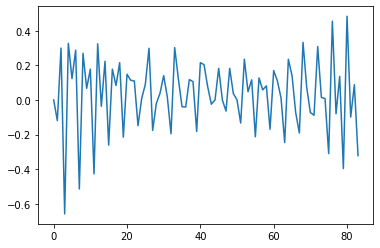

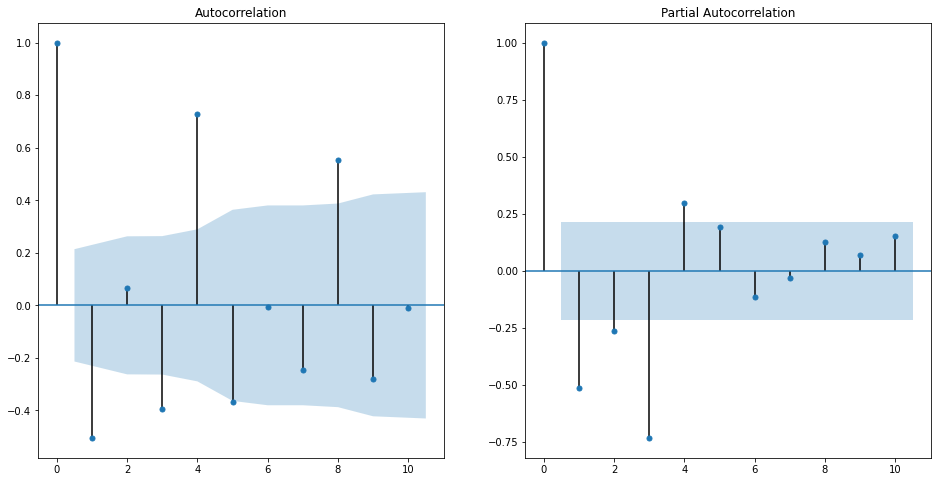

In [15]:
plt.plot(DS_JS_ds)
plotCF(DS_JS_ds,10,True)

## AR model

Results:
	MSE		 0.012480112272119984
	RMSE		 0.11171442284736552
	R2		 0.7109488385676844
	NSE		 0.7107772926712685

Model Params
	 const 	 0.036839064600465314
	 ar.L1 	 -0.8909763069172778
	 ar.L2 	 -0.7943600221950466
	 ar.L3 	 -0.7691260634282034
	 sigma2 	 0.012088126542780768


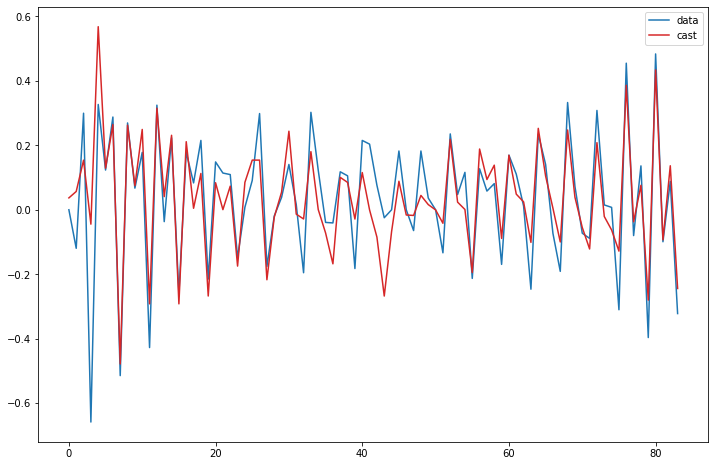

In [16]:
ex = DS_JS_t
ey = DS_JS_ds # use stationary version
eo = (3,0,0) # p,d,q

model_AR = ARIMA(endog=ey, order=eo)
result_AR = model_AR.fit()
cast_AR = result_AR.predict()

show_results(ey, cast_AR, result_AR)

## MA model

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Results:
	MSE		 0.022086152227987727
	RMSE		 0.1486141050775051
	R2		 0.5135944826238222
	NSE		 0.4881603143808887

Model Params
	 const 	 0.03702529726952349
	 ma.L1 	 -1.2438475344731181
	 ma.L2 	 0.5088391163459071
	 sigma2 	 0.021702822837258932


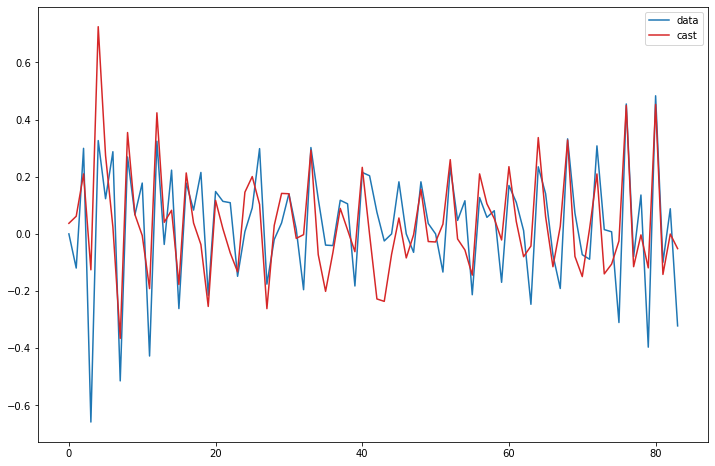

In [17]:
ex = DS_JS_t
ey = DS_JS_ds # use stationary version
eo = (0,0,2) # p,d,q

model_MA = ARIMA(endog=ey, order=eo)
result_MA = model_MA.fit()
cast_MA = result_MA.predict()

show_results(ey, cast_MA, result_MA)

## ARMA model

Results:
	MSE		 0.011424246983850233
	RMSE		 0.10688426911314046
	R2		 0.7353319358282707
	NSE		 0.7352466412307374

Model Params
	 const 	 0.03551427035808875
	 ar.L1 	 -1.0403057342335171
	 ar.L2 	 -1.0194623261543847
	 ar.L3 	 -0.8924642610108211
	 ma.L1 	 0.4637309739693148
	 ma.L2 	 0.4013078952719088
	 sigma2 	 0.010033964330889492


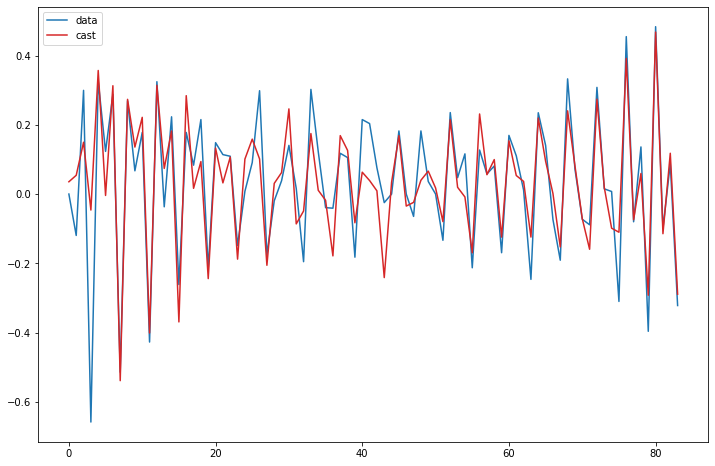

In [18]:
ex = DS_JS_t
ey = DS_JS_ds # use stationary version
eo = (3,0,2) # p,d,q

model_ARMA = ARIMA(endog=ey, order=eo)
result_ARMA = model_ARMA.fit()
cast_ARMA = result_ARMA.predict()

show_results(ey, cast_ARMA, result_ARMA)

## CF for Nonstationary version

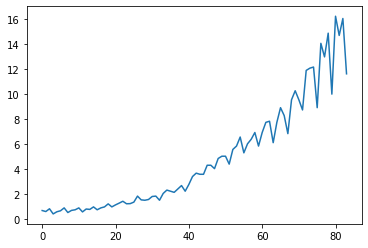

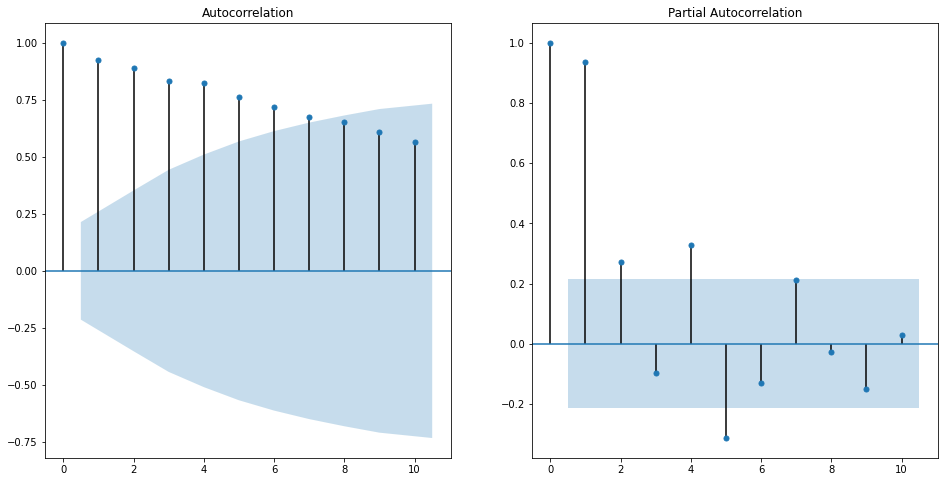

In [19]:
plt.plot(DS_JS_d)
plotCF(DS_JS_d,10,True)

## ARIMA model

Results:
	MSE		 0.36622822750414835
	RMSE		 0.6051679333078945
	R2		 0.9877255587772988
	NSE		 0.9800660401256867

Model Params
	 ar.L1 	 -1.0458589293080736
	 ar.L2 	 -1.0116630479948177
	 ar.L3 	 -0.9332585365297286
	 ma.L1 	 0.6617149445698347
	 ma.L2 	 0.5959755020274513
	 sigma2 	 0.36522478632101163


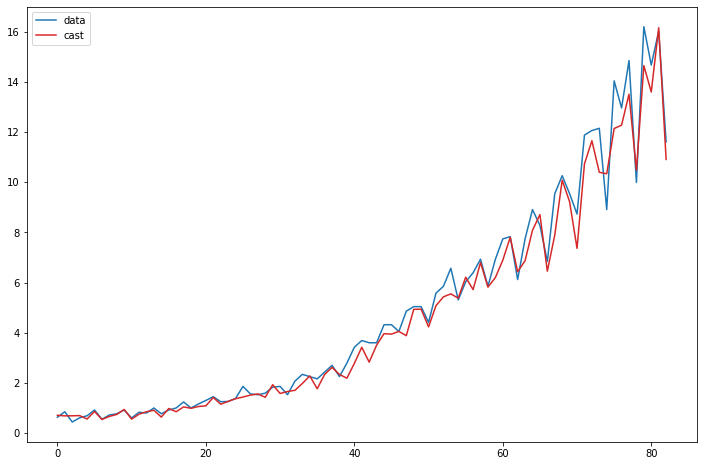

In [45]:
ex = DS_JS_t
ey = DS_JS_d # use non-stationary version
eo = (3,1,2) # p,d,q

model_ARIMA = ARIMA(endog=ey, order=eo)
result_ARIMA = model_ARIMA.fit( )

cast_ARIMA = result_ARIMA.predict()

show_results(ey[1:], cast_ARIMA[1:], result_ARIMA)

## SARIMA model

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Results:
	MSE		 0.18857824690176622
	RMSE		 0.4342559693334868
	R2		 0.9904634149376869
	NSE		 0.9897380213059728

Model Params
	 ar.S.L2 	 -0.26971422380390675
	 ar.S.L4 	 0.9662888816950407
	 ar.S.L6 	 0.2595089283716881
	 ma.S.L2 	 -0.22651824369327622
	 ma.S.L4 	 -0.21094341577140935
	 sigma2 	 0.18761639590574536


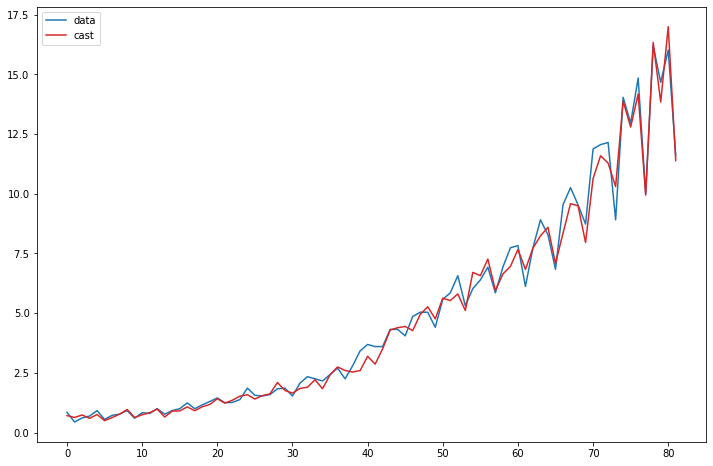

In [44]:
ex = DS_JS_t
ey = DS_JS_d # use non-stationary version
eo = (3,1,2,2) # p,d,q,s

model_SARIMA = ARIMA(endog=ey, seasonal_order=eo)
result_SARIMA = model_SARIMA.fit( )
cast_SARIMA = result_SARIMA.predict()

show_results(ey[2:], cast_SARIMA[2:], result_SARIMA)



---



# EP DATASET

## CF for Stationary Version

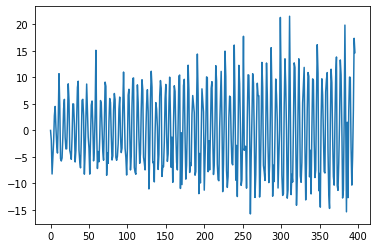

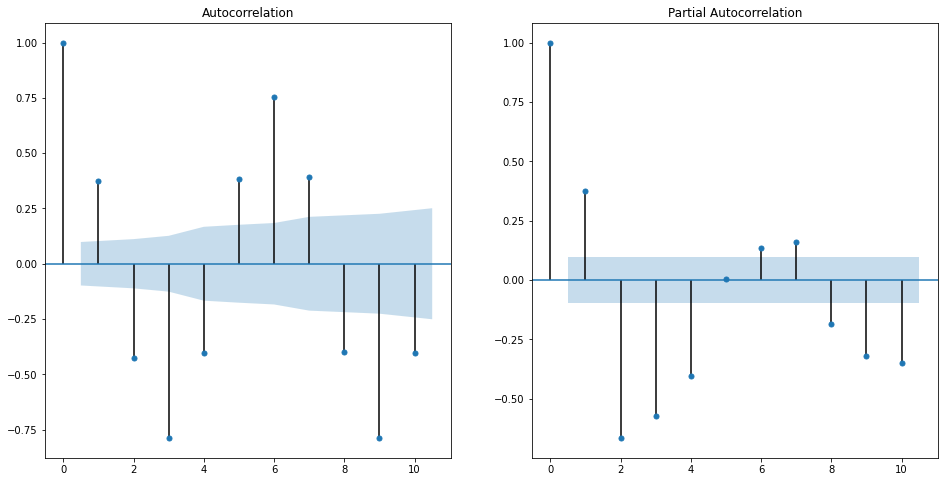

In [24]:
plt.plot(DS_EP_ds)
plotCF(DS_EP_ds,10,True)

## AR model

Results:
	MSE		 15.176303035204066
	RMSE		 3.8956774809016297
	R2		 0.7470203313465786
	NSE		 0.746992204421119

Model Params
	 const 	 0.10921068936523712
	 ar.L1 	 -0.06448983384933588
	 ar.L2 	 -0.47909243651662314
	 ar.L3 	 -0.519550419514385
	 ar.L4 	 -0.4508822746976599
	 ar.L5 	 -0.07685464843180317
	 sigma2 	 15.107208602975438


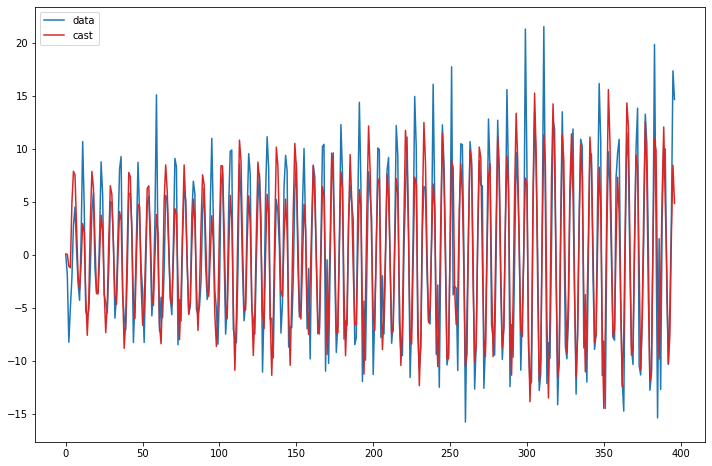

In [33]:
ex = DS_EP_t
ey = DS_EP_ds # use stationary version
eo = (5,0,0) # p,d,q

model_AR = ARIMA(endog=ey, order=eo)
result_AR = model_AR.fit()
cast_AR = result_AR.predict()

show_results(ey, cast_AR, result_AR)

## MA model

Results:
	MSE		 21.91265100077538
	RMSE		 4.6810950642745315
	R2		 0.6396328623555081
	NSE		 0.6346889283816288

Model Params
	 const 	 0.10660354894411722
	 ma.L1 	 -0.10903141144347722
	 ma.L2 	 -0.8688103705636003
	 ma.L3 	 -0.5462326273710382
	 ma.L4 	 0.22858112536897832
	 ma.L5 	 0.40312697233592687
	 sigma2 	 21.78951446534636


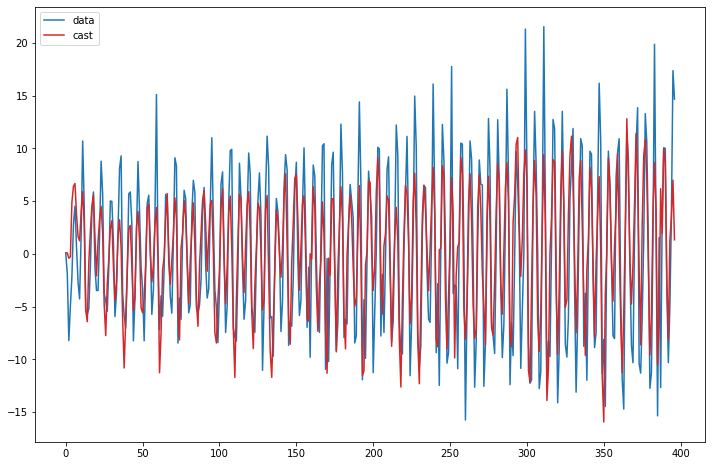

In [34]:
ex = DS_EP_t
ey = DS_EP_ds # use stationary version
eo = (0,0,5) # p,d,q

model_MA = ARIMA(endog=ey, order=eo)
result_MA = model_MA.fit()
cast_MA = result_MA.predict()

show_results(ey, cast_MA, result_MA)

## ARMA model

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Results:
	MSE		 11.290290399440758
	RMSE		 3.3601027364413665
	R2		 0.8121024119040259
	NSE		 0.8117768550890365

Model Params
	 const 	 0.12665774903300744
	 ar.L1 	 0.8559851545283123
	 ar.L2 	 -0.8554611114515135
	 ar.L3 	 -0.1438970441461704
	 ma.L1 	 -1.0377428669457274
	 ma.L2 	 0.9753792313616776
	 sigma2 	 11.09551948880931


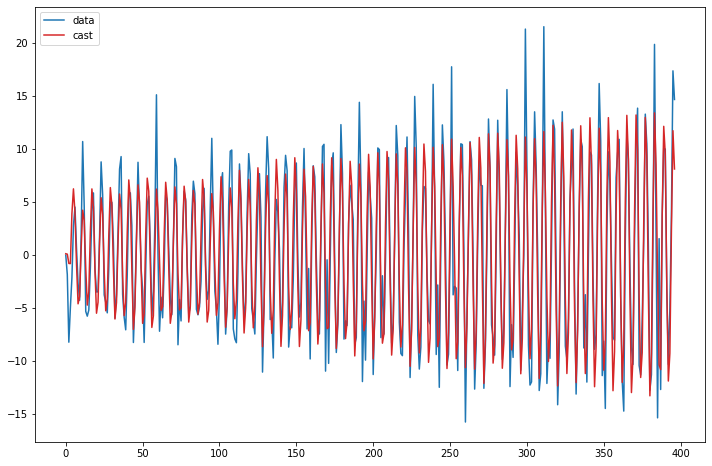

In [35]:
ex = DS_EP_t
ey = DS_EP_ds # use stationary version
eo = (3,0,2) # p,d,q

model_ARMA = ARIMA(endog=ey, order=eo)
result_ARMA = model_ARMA.fit()
cast_ARMA = result_ARMA.predict()

show_results(ey, cast_ARMA, result_ARMA)

## CF for Nonstationary version

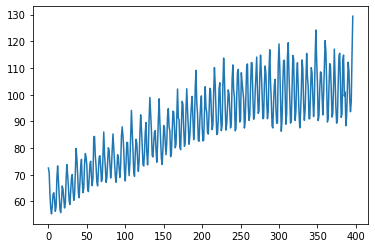

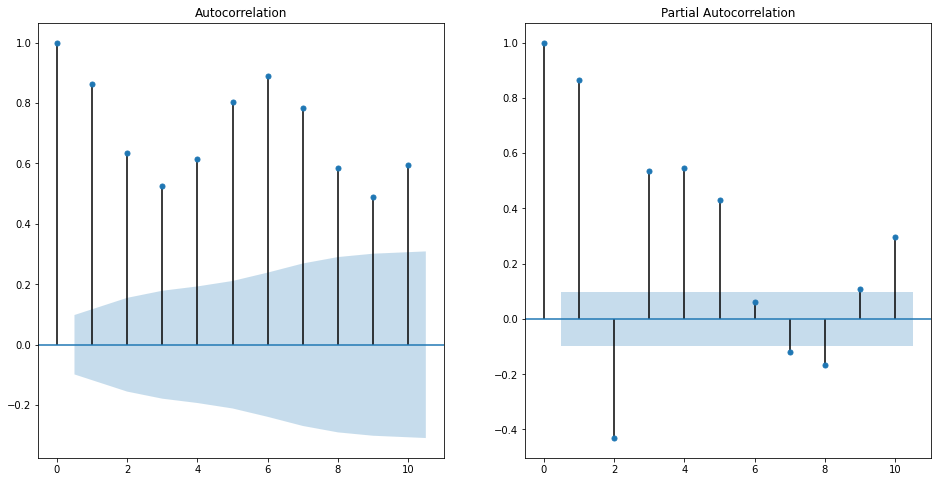

In [36]:
plt.plot(DS_EP_d)
plotCF(DS_EP_d,10,True)

## ARIMA model

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Results:
	MSE		 10.490793177082665
	RMSE		 3.2389493940292837
	R2		 0.9566715544984463
	NSE		 0.9555680690724273

Model Params
	 ar.L1 	 0.6411803035044211
	 ar.L2 	 -0.04833856561684135
	 ar.L3 	 -0.971823040942065
	 ar.L4 	 0.6148713452503725
	 ar.L5 	 -0.02265216429197606
	 ma.L1 	 -0.8906810761929849
	 ma.L2 	 0.0011094128264467398
	 ma.L3 	 0.8979842434701826
	 ma.L4 	 -0.8513529373294586
	 sigma2 	 9.592182817677157


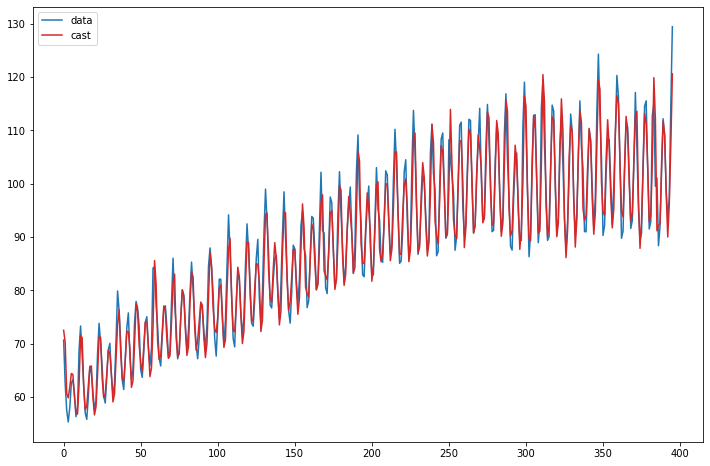

In [41]:
ex = DS_EP_t
ey = DS_EP_d # use non-stationary version
eo = (5,1,4) # p,d,q

model_ARIMA = ARIMA(endog=ey, order=eo)
result_ARIMA = model_ARIMA.fit( )

cast_ARIMA = result_ARIMA.predict()

show_results(ey[1:], cast_ARIMA[1:], result_ARIMA)

## SARIMA model

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Results:
	MSE		 16.173024877959346
	RMSE		 4.021569951891841
	R2		 0.9342726482641461
	NSE		 0.931430963325182

Model Params
	 ar.S.L2 	 -0.5932492864761123
	 ar.S.L4 	 -0.5926165169590922
	 ar.S.L6 	 0.40385042342475297
	 ma.S.L2 	 0.044694504526204604
	 ma.S.L4 	 0.20278416435335855
	 ma.S.L6 	 -0.8283281023454314
	 sigma2 	 14.526672804373103


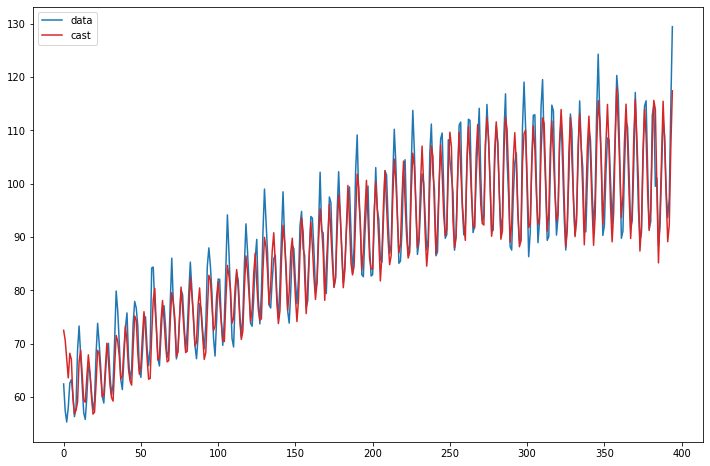

In [43]:
ex = DS_EP_t
ey = DS_EP_d # use non-stationary version
eo = (3,1,3,2) # p,d,q,s

model_SARIMA = ARIMA(endog=ey, seasonal_order=eo)
result_SARIMA = model_SARIMA.fit( )
cast_SARIMA = result_SARIMA.predict()

show_results(ey[2:], cast_SARIMA[2:], result_SARIMA)